In [17]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from keras import callbacks
import numpy as np
import tensorflow as tf

C:\Users\hanse\AppData\Local\Temp/ipykernel_3864/3762802835.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'Tag', 'POS', 'Dep', 'Polarity', 'sentiment'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,Tag,POS,Dep,Polarity,sentiment
0,406733,"[Whip, DIY, skincare, treatment]","[whip, diy, skincare, treatment]","[VB, NN, NN, NN]","[VERB, NOUN, NOUN, NOUN]","[ROOT, COMPOUND, COMPOUND, DOBJ]","[0.0032185039427020004, 0.007093743507093001, ...","[2.0, 2.0, 2.0, 2.0]"
1,457207,"[dusty, rose, berry, burgundy, blushes, beauty...","[dusty, rise, berry, burgundy, blush, beauty, ...","[JJ, VBD, NN, NN, NNS, NN, NN, NN, JJ, VBG, JJ...","[ADJ, VERB, NOUN, NOUN, NOUN, NOUN, NOUN, NOUN...","[NSUBJ, ROOT, CONJ, COMPOUND, CONJ, COMPOUND, ...","[0.0008802730399210001, -0.13539414901264102, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ..."
2,562528,"[followed, suit, condemning, actions]","[follow, suit, condemn, action]","[VBD, NN, VBG, NNS]","[VERB, NOUN, VERB, NOUN]","[ROOT, DOBJ, PCOMP, DOBJ]","[-0.153277040720876, 0.006368119734845, -0.006...","[2.0, 2.0, 2.0, 2.0]"
3,614752,"[Mrs., wearing, bright, spring, time, hues, la...","[Mrs., wear, bright, spring, time, hue, lately...","[NNP, VBG, JJ, NN, NN, NNS, RB, VBD, NNS, NN, ...","[PROPN, VERB, ADJ, NOUN, NOUN, NOUN, ADV, VERB...","[COMPOUND, ADVCL, AMOD, COMPOUND, COMPOUND, DO...","[0.013559198044936, 0.219309772653784, 0.01415...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ..."
4,556390,"[failing, Life, Good]","[fail, life, good]","[VBG, NN, JJ]","[VERB, NOUN, ADJ]","[ROOT, NSUBJ, AMOD]","[-0.11598095226000801, -0.17466957345869003, -...","[2.0, 2.0, 2.0]"


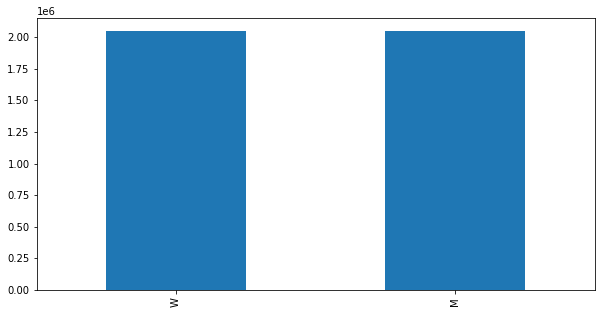

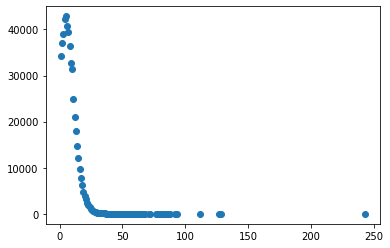

In [18]:
import pandas as pd

df = pd.read_json('../datasets/7_dataset_w_tags_SM.json')

M, W = df["Gender"].value_counts()
if M>W:
    diff = M-W
    df = df.drop(df.loc[df['Gender'] == 'M'].index[:diff], axis=0)
elif W>M:
    diff = W-M
    df = df.drop(df.loc[df['Gender'] == 'W'].index[:diff], axis=0)

df["Gender"].value_counts().plot(kind="bar", figsize=(10,5))
df['sentiment'] = df.Gender.apply(lambda x: 0. if x == "M" else 2.)
df = df.drop('Gender', axis=1)
df['Dep'] = df['Dep'].str.upper()
df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'Tag', 'POS', 'Dep', 'Polarity', 'sentiment'].agg(lambda x: list(x))
df = df.sample(frac=1).reset_index(drop=True)

from collections import Counter

counts = [len(row) for row in df["sentiment"]]
fig, ax = plt.subplots()
ax.scatter(Counter(counts).keys(), Counter(counts).values())


split = round(len(df)*0.6)
train_data = df[:split]
test_data = df[split:]

train_data.head(5)

In [19]:
import os
import time
import tensorflow as tf
from keras import callbacks

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

model_name = 'words_binary_single_feature'
model_variant = 'base'

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        exp = lr0 * 0.1**(epoch / s)
        tf.summary.scalar('learning rate', data=exp, step=epoch)
        return exp
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=10)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

mcp_save = callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

my_callbacks = [earlystopping, lr_scheduler, tensorboard_cb]

In [20]:
# Borrowed from: https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f
vocab_size = 40000
embedding_dim = 16
max_length = 20 #max([len(w) for w in train_data['Lemma']])
padding_type = 'post'
trunc_type = 'post'
oov_tok = '<OOV>'
output_dim = 64

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data['Lemma'])

train_seqs = tokenizer.texts_to_sequences(train_data['Lemma'])
X_train = pad_sequences(train_seqs, maxlen=max_length, dtype='float32', padding=padding_type, truncating=trunc_type, value=1.)
test_seqs = tokenizer.texts_to_sequences(test_data['Lemma'])
X_test = pad_sequences(test_seqs, maxlen=max_length, dtype='float32', padding=padding_type, truncating=trunc_type, value=1.)

y_train = pad_sequences(train_data['sentiment'], maxlen=max_length, dtype='float32', padding=padding_type, truncating=trunc_type, value=1.)
y_test = pad_sequences(test_data['sentiment'], maxlen=max_length, dtype='float32', padding=padding_type, truncating=trunc_type, value=1.)

y_train = [to_categorical(i, num_classes=3) for i in y_train]

model = tf.keras.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        layers.LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        layers.LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.2),
        # layers.Dense(3, activation='sigmoid'),
        layers.TimeDistributed(layers.Dense(3, activation="softmax"))
])

adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 

model.summary()

history = model.fit(X_train, np.array(y_train), epochs=50, callbacks =my_callbacks, validation_split=0.2)

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 16)            640000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 64)            20736     
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 64)            33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 3)             195       
Total params: 693,955
Trainable params: 693,955
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7701/7701 [==============================] - 230s 29ms/step - loss: 0.1873 - accuracy: 0.9087 - val_loss: 0.1765 - val_accuracy: 0.9168
Epoch 2/50
7701/7701 [==============================] - 221s 29ms/step - loss: 0.1633 - accuracy: 0

<Figure size 432x288 with 0 Axes>

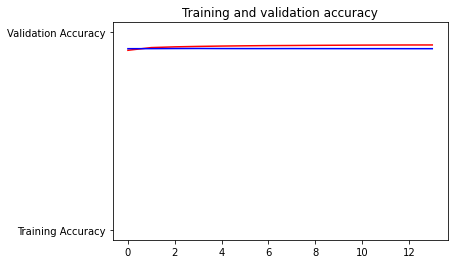

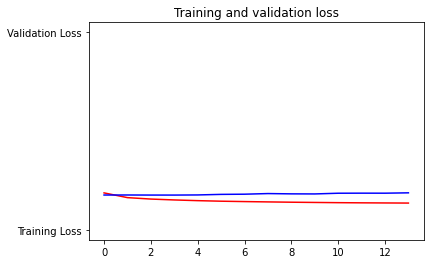

<Figure size 432x288 with 0 Axes>

In [21]:
# %load_ext tensorboard
# %tensorboard --logdir=./la_logs --port=6006

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

In [22]:
model.save('classifiers/' + model_name + '/' + model_variant + '.h5')


In [23]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

In [24]:
rep_to_pol = {
  0 : -1.0,
  1 : 0.0,
  2 : 1.0
}

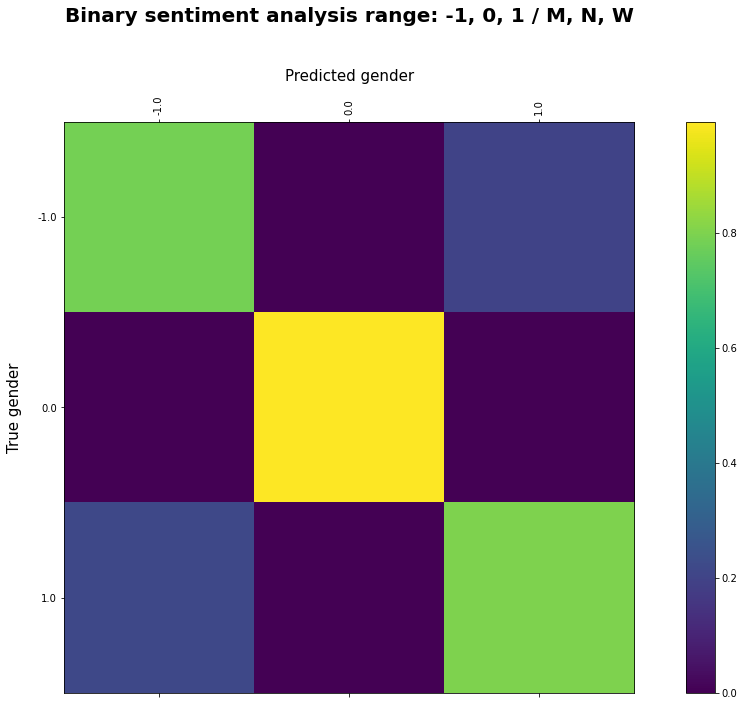

In [25]:
from sklearn.metrics import confusion_matrix

y_test = np.array(y_test).flatten()
y_pred = y_pred.flatten()
cm = confusion_matrix(y_test, y_pred, normalize='pred')

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted gender', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True gender', fontsize = 15, labelpad=15.0)
ax.set_title('Binary sentiment analysis range: -1, 0, 1 / M, N, W',fontweight="bold", size=20, pad=100.0)

cm_axis_vals = []

for x in np.unique(np.array(y_pred)):
    cm_axis_vals.append(rep_to_pol[x])

fig.colorbar(cax)
plt.xticks(range(3), cm_axis_vals, rotation=90)
plt.yticks(range(3), cm_axis_vals)
plt.show()

In [26]:
from sklearn.metrics import classification_report
sentiment_vocab = ['M', 'N', 'W']

report = classification_report(y_test, y_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:3]
df_perf_2.insert(loc=0, column='Gender', value=sentiment_vocab)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\hanse\AppData\Local\Temp/ipykernel_3864/1332072178.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Gender,precision,recall,f1-score,support
0,M,0.79,0.79,0.79,804176.0
1,N,0.99,1.00,1.00,2494221.0
2,W,0.80,0.77,0.79,808523.0
